# 0. Package Import and Definitions of Settings

In [251]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.integrate import trapezoid, cumulative_trapezoid
from rtdpy import AD_cc
import pathlib
import matplotlib.pyplot as plt
from ICIW_Plots import make_square_subplots, cm2inch
import os

In [252]:
# set plot parameters
plt.style.use("ICIWstyle")
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] # get colors from the current style cycle
# update labelsize to 10
plt.rcParams.update({'axes.labelsize': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10, 'axes.titlesize': 10})

# define paths
project_root = pathlib.Path.cwd() / "FallingFilmLoopingPhotoreactor"
project_root = project_root.resolve()

data_path = project_root / "01_Experiments" / "00_RTD" / "00_External_Flow_Rate_Variation"
output_path = project_root / "02_Software" / "00_RTD_Model" / "00_Processed_Data"
figures_path = project_root / "02_Software" / "00_RTD_Model" / "01_Figures"
output_path.mkdir(parents=True, exist_ok=True)
figures_path.mkdir(parents=True, exist_ok=True)

# convert paths to strings for compatibility
data_path = str(data_path)
output_path = str(output_path)
figures_path = str(figures_path)


# 1. Implementation of Model Equations and Auxiliary Functions

In [253]:
V = 20e-6 # reactor volume in m^3

In [254]:
def preprocessing(file, path="experimental_data/", window_size=10):
    """
    Preprocesses the experimental data by performing the following steps:
    1. Baseline correction using linear regression
    2. Normalization by integrating the area under the curve
    3. Smoothing using running average
    4. Set time of injection to t = 0 and set dt to a fixed value by interpolating
    5. Calculate experimental E- and F-function from the normalized voltage

    Parameters
    ----------
    file : str
        Name of the file containing the experimental data.
    path : str, optional
        Path to the file containing the experimental data. The default is "experimental_data/".
    window_size : int, optional
        The window size for the running average. The default is 10.

    Returns
    -------
    preprocessed_data : pd.DataFrame
        A DataFrame containing the preprocessed data.
        Time (s): Time in seconds since the peak of the outlet signal.
        E_exp_in (s-1): Experimental E-function at the inlet.
        E_exp_out (s-1): Experimental E-function at the outlet.
        F_exp_in (1): Experimental F-function at the inlet.
        F_exp_out (1): Experimental F-function at the outlet.
    """

    data = pd.read_csv(path+"/"+file)
    
    # Extract relevant columns
    time = pd.to_datetime(data["Timestamp"]).astype(np.int64) / 1e9  # Convert to seconds
    adjusted_voltage_in = data["Adjusted Voltage Channel 1"] #  measured voltage at the inlet
    adjusted_voltage_out = data["Adjusted Voltage Channel 0"] # measured voltage at the outlet
    
    # baseline correction using linear regression
    def correct_baseline(time, voltage):
        baseline_indices = [0, len(voltage) - 1]
        baseline_times = time[baseline_indices].values.reshape(-1, 1)
        baseline_voltages = voltage[baseline_indices].values
        
        model = LinearRegression()
        model.fit(baseline_times, baseline_voltages)
        baseline = model.predict(time.values.reshape(-1, 1))
        corrected_voltage = voltage - baseline

        # clip negative values to 0
        corrected_voltage[corrected_voltage < 0] = 0
        
        return corrected_voltage

    corrected_voltage_in = correct_baseline(time, adjusted_voltage_in)
    corrected_voltage_out = correct_baseline(time, adjusted_voltage_out)

    # normalize voltages by integrating the area under the curve
    def normalize(time, voltage):
        area = np.trapezoid(voltage, time)
        return voltage / area
    
    # Normalize the corrected voltages to get E_exp_in and E_exp_out
    E_exp_in_noisy = normalize(time, corrected_voltage_in)
    E_exp_out_noisy = normalize(time, corrected_voltage_out)

    # Apply running average (smoothing) to the corrected voltages
    E_exp_in_smoothend = E_exp_in_noisy.rolling(window=window_size, min_periods=1).mean()
    E_exp_out_smoothend = E_exp_out_noisy.rolling(window=window_size, min_periods=1).mean()

    # set time of injection to t = 0 and fix dt by interpolating
    peak_time_in = time[np.argmax(E_exp_in_smoothend)]
    shifted_time = time - peak_time_in
    shifted_time_corr = np.linspace(shifted_time.min(), shifted_time.max(), len(shifted_time))


    # interpolate the smooth
    E_exp_in = np.interp(shifted_time_corr, shifted_time, E_exp_in_smoothend) 
    E_exp_out = np.interp(shifted_time_corr, shifted_time, E_exp_out_smoothend)

    # integrate E to get F
    F_exp_in = cumulative_trapezoid(E_exp_in, shifted_time_corr, initial=0) 
    F_exp_out = cumulative_trapezoid(E_exp_out, shifted_time_corr, initial=0)

    
    preprocessed_data = pd.DataFrame({
        "Time (s)": shifted_time_corr,
        "E_exp_in (s-1)": E_exp_in,
        "E_exp_out (s-1)": E_exp_out,
        "F_exp_in (1)": F_exp_in,
        "F_exp_out (1)": F_exp_out,
        })
    
    # remove rows with time < 0
    preprocessed_data = preprocessed_data[preprocessed_data["Time (s)"] >= 0]

    # add flow rate from the file name
    flow_rate = float(file.split("mL")[0])  # assuming the file name contains the flow rate in mL min-1
    preprocessed_data.attrs["Flow Rate (mL min-1)"] = flow_rate

    return preprocessed_data

In [255]:
def calc_tau(preprocessed_data):
    """
    Calculates the residence time from the preprocessed data.

    Parameters
    ----------
    preprocessed_data : pd.DataFrame
        Preprocessed data.

    Returns
    -------
    tau : float
        Residence time.

    """

    # Calculate the residence time as the mean of the time values
    tau = trapezoid(preprocessed_data["E_exp_out (s-1)"]*preprocessed_data["Time (s)"], preprocessed_data["Time (s)"])

    return tau


def objective(Bo, tau, preprocessed_data):
    """
    Objective function to minimize for the optimization problem.

    Parameters
    ----------
    Bo : float
        Bodenstein number.
    tau : float
        Residence time.
    processed_data : pd.DataFrame
        Preprocessed data.

    Returns
    -------
    total_squared_error : float
        Sum of squared errors between simulated and experimental data.

    """

    E_sim = AD_cc(tau, Bo, dt=preprocessed_data["Time (s)"].values[1] - preprocessed_data["Time (s)"].values[0], time_end=preprocessed_data["Time (s)"].values[-1], a=1000).exitage # simulate the exit age distribution
    total_squared_error = sum((E_sim - preprocessed_data["E_exp_out (s-1)"].values)**2) # sum of squared errors between simulated and experimental data
    return total_squared_error


def fit_Bo(preprocessed_data, tau, Bo_init=1):
    """
    Fits the Bodenstein number to the preprocessed data.

    Parameters
    ----------
    preprocessed_data : pd.DataFrame
        Preprocessed data.
    tau : float
        Residence time.
    Bo_init : float
        Initial guess for the Bodenstein number. Default is 1.

    Returns
    -------
    Bo : float
        Optimized Bodenstein number.

    """

    Bo = minimize(objective, Bo_init, method='Nelder-Mead', bounds=[(1e-6, None)], args=(tau,preprocessed_data)).x[0] # optimize the Bodenstein number
    
    return Bo

In [256]:
def calculate_RTD_functions(preprocessed_data, tau, Bo):
    """
    Fits the model to the experimental data by minimizing the objective function.
    
    Parameters
    ----------
    Bo : float
        Bodenstein number.
    tau : float
        Residence time.
    processed_data : pd.DataFrame
        Preprocessed data.
    
    Returns
    -------
    float
        Sum of squared errors between the simulated and experimental data.
    """

    dt = preprocessed_data["Time (s)"].diff().iloc[1]  # calculate dt from the preprocessed data
    E_sim = AD_cc(tau, Bo, dt=dt, time_end=preprocessed_data["Time (s)"].iloc[-1], a=1000).exitage  # simulate the exit age distribution
    F_sim = cumulative_trapezoid(E_sim, preprocessed_data["Time (s)"].values, initial=0)  # integrate the exit age distribution to get the exit age distribution function
    return E_sim, F_sim


def process_file(file, t_end=None, path="experimental_data/", window_size=10, Bo_init=1, export_path=""):
    """
    Processes the experimental data by preprocessing and calculating the exit age distribution.

    Parameters
    ----------
    file : str
        Name of the file containing the experimental data.
    path : str, optional
        Path to the file containing the experimental data. The default is "experimental_data/".
    window_size : int, optional
        The window size for the running average. The default is 10.
    Bo_init : float, optional
        Initial guess for the Bodenstein number. The default is 1.

    Returns
    -------
    preprocessed_data : pd.DataFrame
        A DataFrame containing the preprocessed data.
    E_sim : np.ndarray
        Simulated exit age distribution.

    """
    
    preprocessed_data = preprocessing(file, path, window_size)  # preprocess the data


    tau= calc_tau(preprocessed_data) # calculate the residence time
    Bo = fit_Bo(preprocessed_data, tau, Bo_init)  # fit the Bodenstein number
    if t_end is None or t_end <= preprocessed_data["Time (s)"].values[-1]:
        t_end = preprocessed_data["Time (s)"].values[-1]  # use the last time value as t_end if not provided
        processed_data = preprocessed_data.copy()  # create a copy of the preprocessed data for further processing
    else: # extend the time range to t_end
        dt = preprocessed_data["Time (s)"].diff().iloc[1]
        time_ext = np.arange(preprocessed_data["Time (s)"].iloc[-1] + dt, t_end + dt, dt)
        nan_cols = {col: np.nan for col in preprocessed_data.columns if col != "Time (s)"}
        ext_data = pd.DataFrame({"Time (s)": time_ext, **nan_cols})
        processed_data = pd.concat([preprocessed_data, ext_data], ignore_index=True)
         
    E_sim, F_sim = calculate_RTD_functions(processed_data, tau, Bo) # calculate the exit age distribution and exit age distribution function

    processed_data["E_sim_out (s-1)"] = E_sim  # add the simulated exit age distribution to
    processed_data["F_sim_out (1)"] = F_sim  # add the simulated exit age distribution function to the processed data
    processed_data.attrs["Bodenstein Number (1)"] = Bo  # add the Bodenstein number to the processed data
    processed_data.attrs["Flow Rate (mL min-1)"] = preprocessed_data.attrs["Flow Rate (mL min-1)"]  # add the flow rate to the processed data
    processed_data.attrs["Residence Time (s)"] = tau  # add the residence time to the processed data
    processed_data.attrs["Hydrodynamic Residence Time (s)"] = V / (preprocessed_data.attrs["Flow Rate (mL min-1)"] * 1e-6 / 60)  # add the hydrodynamic residence time to the processed data

    if export_path:
        # export the processed data to a csv file
        export_file = f"/{file.split('.csv')[0]} processed.csv"
        processed_data.to_csv(export_path + export_file, index=False)

    return processed_data


# 2. Plotting Functions

In [257]:
def create_tau_Bo_plot(processed_data_list, store_path=None, filetype="svg"):
    """
    Creates a plot of the hydrodynamic and measured mean residence time against flow rate on the left axis 
    and the Bodenstein number on the right axis.

    Parameters
    ----------
    processed_data_list : list of pd.DataFrame
        List of preprocessed data DataFrames for different flow rates.
    store_path : str, optional
        Path to store the plot. If None, the plot is not saved.
    filetype : str, optional
        File type to save the plot.
    """

    fig = plt.figure(figsize=(19 * cm2inch, 12 * cm2inch))
    axs = make_square_subplots(
        fig=fig,
        ax_width=8 * cm2inch,
        ax_layout=(1, 1),
        h_sep=0,
        v_sep=0,
        xlabel="$\\dot{V}_\mathrm{ext}$ / mL min$^{-1}$",
        ylabel="$\\bar{\\tau}$ / min"
    )
    ax1 = axs[0][0]
    ax2 = ax1.twinx()

    # get required data from processed_data_list
    flow_rates = [processed_data.attrs["Flow Rate (mL min-1)"] for processed_data in processed_data_list]
    residence_times = [processed_data.attrs["Residence Time (s)"]/60 for processed_data in processed_data_list]
    hydrodynamic_residence_times = [processed_data.attrs["Hydrodynamic Residence Time (s)"]/60 for processed_data in processed_data_list]
    Bodenstein_numbers = [processed_data.attrs["Bodenstein Number (1)"] for processed_data in processed_data_list]

    # Plot lines
    ax1.plot(flow_rates, residence_times, 'o--', label="$\\bar{\\tau}$", color=cycle[0])
    ax1.plot(flow_rates, hydrodynamic_residence_times, 's:', label="$\\bar{\\tau}_\mathrm{h}$", color=cycle[1])
    ax2.plot(flow_rates, Bodenstein_numbers, 'D-.', label="Bo", color=cycle[2])

    ax1.set_ylim(0, max(residence_times + hydrodynamic_residence_times) + 0.1)
    ax2.set_ylabel("Bo / 1")
    ax2.set_ylim(0, 3)

    ax1.grid(False)
    ax2.grid(False)

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

    if store_path:
        plt.savefig(store_path + f"/tau_Bo_plot.{filetype}", dpi=300, bbox_inches='tight')
    plt.show()



In [258]:
def create_comparison_plots(processed_data_list, t_end, colors=cycle, store_path=None, filetype="svg"):
    """
    Creates a comparison plot for the exit age distribution of different flow rates.
    The plot shows the experimental data and the simulated data for each flow rate.

    Parameters
    ----------
    processed_data_list : list of pd.DataFrame
        List of preprocessed data DataFrames for different flow rates.
    t_end : float
        End time for the simulation, used to set the x-axis limit.
    colors : list of str, optional
        List of colors for the experimental and simulated data lines. The default is the current style cycle colors.
    store_path : str, optional
        Path to the folder where the plot will be saved. The default is None, which means the plot will not be saved.
    filetype : str, optional
        File type for saving the plot. The default is "svg". Other options could be "png", "pdf", etc.
    """

    # create five subplots for each flow rate
    plt.style.use("ICIWstyle")

    fig = plt.figure(figsize=(19*cm2inch, 15*cm2inch))
    axs = make_square_subplots(
        fig=fig,
        ax_width=5 * cm2inch,
        ax_layout=(2, 3),
        h_sep=1 * cm2inch,
        v_sep=2.5 * cm2inch,
        sharex=False,  # share the axis
        sharey=True,  # share the axis
        sharelabel=True,
        xlabel="$t$ / s",  # every x axis has the same label
        ylabel=["$E(t)$ / s$^{-1}$", "$E(t)$ / s$^{-1}$"],  # every y axis along the rows has the same label

    )

    j = 0
    for processed_data in processed_data_list:
        Bo_opt = processed_data.attrs["Bodenstein Number (1)"]
        axs[j//3,j%3].plot(processed_data["Time (s)"], processed_data["E_exp_out (s-1)"], label="exp.", color=colors[0])
        axs[j//3,j%3].plot(processed_data["Time (s)"], processed_data["E_sim_out (s-1)"], label="sim.", linestyle="--", color=colors[1])
        axs[j//3,j%3].set_title(chr(j+97) +") "+str(processed_data.attrs["Flow Rate (mL min-1)"]) +r" mL min$^{-1}$", y=-0.4, fontsize=10)

        # add fitted Bo-number at the upper left corner of the subplot
        axs[j//3,j%3].text(0.03, 0.97, r"$\mathrm{Bo} = $"+str(round(Bo_opt,2)), transform=axs[j//3,j%3].transAxes, ha='left', va='top', fontsize=10)
        j += 1

    # plot all simulated E functions in axs[1,2]
    for processed_data in processed_data_list:
        axs[1,2].plot(processed_data["Time (s)"], processed_data["E_sim_out (s-1)"], label=str(processed_data.attrs["Flow Rate (mL min-1)"]) + r" mL min$^{-1}$")
    axs[1,2].set_title("f) all simulated $E(t)$", y=-0.4, fontsize=10)

    # get the maximum E(t) value for all flow rates to set the y-axis limit
    E_t_max = max(processed_data["E_sim_out (s-1)"].max() for processed_data in processed_data_list) 

    # set the x and y limits for all subplots and disable grid
    for ax in axs.flatten():
        ax.set_xlim(-30, t_end)
        ax.set_ylim(-0.0002, E_t_max+0.002)
        ax.grid(False)
        ax.legend(loc="upper right")



    # # # remove last subplot and put legend there instead
    # axs[1,2].axis('off')
    # axs[1,1].legend(loc="center right", bbox_to_anchor=(2.2, 0.5), ncol=1)
        
    # save figure
    if store_path:
        plt.savefig(store_path + "/comparison_plot."+filetype, dpi=300, bbox_inches='tight')
                

In [259]:
def create_all_simulated_RTDs_plot(processed_data_list, t_end, store_path=None, filetype="svg"):
    """
    Creates a plot for the simulated exit age distribution of all flow rates.

    Parameters
    ----------
    processed_data_list : list of pd.DataFrame
        List of preprocessed data DataFrames for different flow rates.
    t_end : float
        End time for the simulation, used to set the x-axis limit.
    E_t_max : float
        Maximum value of E(t) for all flow rates, used to set the y-axis limit.
    store_path : str, optional
        Path to the folder where the plot will be saved. The default is None, which means the plot will not be saved.
    filetype : str, optional
        File type for saving the plot. The default is "svg". Other options could be "png", "pdf", etc.
    """
    
    fig = plt.figure(figsize=(19*cm2inch, 12*cm2inch))
    axs = make_square_subplots(
        fig=fig,
        ax_width=8 * cm2inch,
        ax_layout=(1, 2),
        h_sep=2 * cm2inch,
        v_sep=0 * cm2inch,
        sharex=True,  # share the axis
        sharey=False,  # share the axis
        sharelabel=False,
        xlabel="$t$ / s",  # every x axis has the same label
        ylabel="$E_\mathrm{sim}(t)$ / s$^{-1}$"

    )

    # plot E_sim and F_sim
    for processed_data in processed_data_list:
        axs[0,0].plot(processed_data["Time (s)"], processed_data["E_sim_out (s-1)"], label=str(processed_data.attrs["Flow Rate (mL min-1)"]) + r" mL min$^{-1}$")
        axs[0,1].plot(processed_data["Time (s)"], processed_data["F_sim_out (1)"])
    
    # set axis limits and disable grid
    for ax in axs.flatten():
        ax.set_xlim(-30, t_end)
        ax.grid(False)
    
    axs[0,0].set_title("a) Residence time density distribution", y=-0.28, fontsize=10)
    axs[0,1].set_title("b) Cumulative residence time distribution", y=-0.28, fontsize=10)
    axs[0,1].set_ylabel("$F_\mathrm{sim}(t)$ / 1")

    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1), ncol=3)

    if store_path:
        plt.savefig(store_path + "/all_simulated_RTDs_plot."+filetype, dpi=300, bbox_inches='tight')


# 3. Result Generation

In [260]:
# define the end time for the simulations
t_end = 800

processed_data_list = []
# iterate through all files in the experimental_data folder independently of the names

for file in pathlib.Path(data_path).glob("*.csv"):
    processed_data = process_file(file.name, t_end=t_end, path=data_path, window_size=10, Bo_init=1, export_path=output_path)
    # print flow rate and residence time
    processed_data_list.append(processed_data)

# sort the processed data by flow rate
processed_data_list.sort(key=lambda x: x.attrs["Flow Rate (mL min-1)"])


In [261]:
# create a dataframe with the flow rates, residence times, and Bodenstein numbers
flow_rates = [processed_data.attrs["Flow Rate (mL min-1)"] for processed_data in processed_data_list]
residence_times = [processed_data.attrs["Residence Time (s)"] for processed_data in processed_data_list]
hydrodynamic_residence_times = [processed_data.attrs["Hydrodynamic Residence Time (s)"] for processed_data in processed_data_list]
Bodenstein_numbers = [processed_data.attrs["Bodenstein Number (1)"] for processed_data in processed_data_list]

# create a dataframe with the flow rates, residence times, and Bodenstein numbers
summary_df = pd.DataFrame({
    "Flow Rate (mL min-1)": flow_rates,
    "Residence Time (s)": residence_times,
    "Hydrodynamic Residence Time (s)": hydrodynamic_residence_times,
    "Bodenstein Number (1)": Bodenstein_numbers
})


summary_df.to_csv(output_path + "/summary_table.csv", index=False)  # save the summary dataframe to a csv file

# print the summary dataframe
print(summary_df)

   Flow Rate (mL min-1)  Residence Time (s)  Hydrodynamic Residence Time (s)  \
0                   3.3          272.021453                       363.636364   
1                   5.0          174.046520                       240.000000   
2                  10.0          119.287662                       120.000000   
3                  20.0           80.911318                        60.000000   
4                  40.0           73.207057                        30.000000   

   Bodenstein Number (1)  
0               0.564453  
1               1.133301  
2               0.534277  
3               0.576465  
4               0.443164  


FileNotFoundError: [Errno 2] No such file or directory: 'figures//tau_Bo_plot.png'

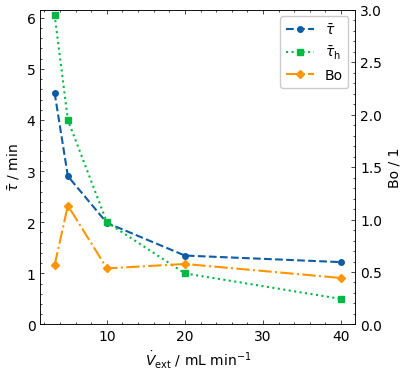

In [ ]:
# create the plot for the hydrodynamic and measured residence time and Bodenstein number
create_tau_Bo_plot(processed_data_list, store_path=figures_path, filetype="png")

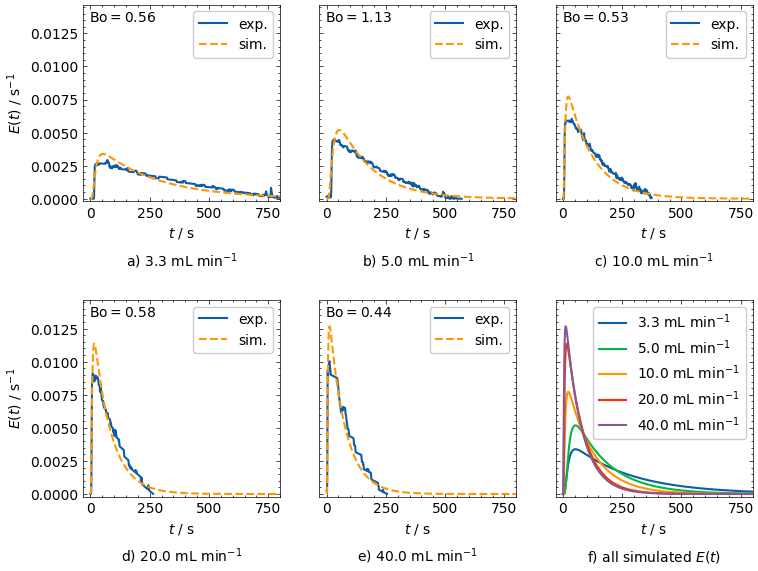

In [ ]:
# create comparison plots for the exit age distribution of different flow rates
create_comparison_plots(processed_data_list, t_end=t_end, colors=[cycle[0], cycle[2]], store_path=figures_path, filetype="png")

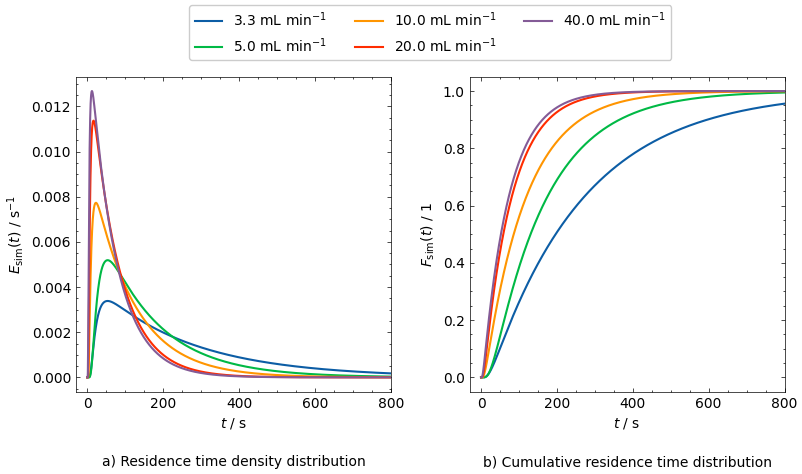

In [ ]:
create_all_simulated_RTDs_plot(processed_data_list, t_end=t_end, store_path=figures_path, filetype="png")